## Setup

In [1]:
import torch
from torch.utils.data import DataLoader, Dataset

from tqdm import tqdm
import json
import os
import pandas as pd

import torch.nn as nn
from torchmetrics import MeanSquaredError, MeanAbsoluteError
from torch.nn.utils.rnn import pad_sequence
from torchmetrics import F1Score, Accuracy

import lightning as L
import random
import pickle

from torch.utils.data import DataLoader
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
from lightning.pytorch.loggers import CSVLogger

from utils import *

with open("data/sub_1000.json","r") as j_file:
    data = json.load(j_file)

/home/kolton.hauck/miniconda3/envs/python310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## HAE

In [2]:
class EncounterAutoencoderV2(nn.Module):
    def __init__(self, embedding_dim=768, hidden_dim=128, output_dim=128):
        super(EncounterAutoencoderV2, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        
        # Define LSTMs for different parts of an encounter
        self.encounter_lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.conditions_lstm = nn.LSTM(embedding_dim, hidden_dim // 2, batch_first=True)
        self.careplans_lstm = nn.LSTM(embedding_dim, hidden_dim // 2, batch_first=True)
        self.procedures_lstm = nn.LSTM(embedding_dim, hidden_dim // 2, batch_first=True)

        # A linear layer to merge all different LSTM outputs
        self.fc = nn.Linear(hidden_dim + 3 * (hidden_dim // 2), output_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        # Assuming x is a dict with structure given by the new dataset format
        # print('pa x', x)
        encounter_out, _ = self.encounter_lstm(x['encounter'])
        conditions_out, _ = self.conditions_lstm(torch.cat(x['conditions'], dim=0))
        careplans_out, _ = self.careplans_lstm(torch.cat(x['careplans'], dim=0))
        procedures_out, _ = self.procedures_lstm(torch.cat(x['procedures'], dim=0))

        # Taking the last hidden state as the representation
        encounter_rep = encounter_out[:, -1, :]
        conditions_rep = conditions_out[:, -1, :]
        careplans_rep = careplans_out[:, -1, :]
        procedures_rep = procedures_out[:, -1, :]

        # Concatenate all outputs
        concatenated = torch.cat((encounter_rep, conditions_rep, careplans_rep, procedures_rep), dim=1)
        
        # Pass through a final linear layer
        final_output = self.fc(concatenated)
        final_output = self.relu(final_output)

        return final_output

class PatientAutoencoderV2(L.LightningModule):
    def __init__(self, embedding_dim=768, hidden_dim=128, patient_latent_dim=64, output_dim=128):
        super(PatientAutoencoderV2, self).__init__()
        self.save_hyperparameters()
        self.encounter_autoencoder = EncounterAutoencoderV2(embedding_dim, hidden_dim, output_dim)
        self.patient_encoder = nn.Sequential(
            nn.Linear(output_dim, patient_latent_dim),  # Adjusted to match EncounterAutoencoder's output
            nn.ReLU(),
            nn.Dropout(0.25)
        )
        self.patient_decoder = nn.Sequential(
            nn.Linear(patient_latent_dim, output_dim),  # Ensure the output dimension matches the encoder's input
            nn.ReLU(),
            nn.Dropout(0.25)
        )

        self.train_mse = nn.MSELoss()
        self.val_mse = nn.MSELoss()
        self.test_mse = nn.MSELoss()

        self.train_mae = nn.L1Loss()
        self.val_mae = nn.L1Loss()
        self.test_mae = nn.L1Loss()

    def forward(self, x):
        print("x", x.shape)
        encounter_representation = self.encounter_autoencoder(x['embeddings'])
        print("enc rep", encounter_representation)
        patient_encoded = self.patient_encoder(encounter_representation)
        print("pat enc", patient_encoded)
        patient_decoded = self.patient_decoder(patient_encoded)
        print("pat dec", patient_decoded)
        return patient_decoded

    # Adjust the common step to match the new structure
    def _common_step(self, batch, batch_idx, loss_metric, acc_metric, loss_lbl, metric_lbl):
        embeddings = batch['embeddings']
        logits = self.forward(embeddings)
        labels = self.encounter_autoencoder(embeddings)

        loss = loss_metric(logits, labels)
        self.log(loss_lbl, loss, prog_bar=True)
        self.log(metric_lbl, acc_metric(logits, labels), prog_bar=True)
        return loss

    def training_step(self, batch, batch_idx):
        return self._common_step(batch, batch_idx, self.train_mse, self.train_mae, "train_mse", "train_mae")

    def on_training_epoch_end(self):
        self.log("train_mse", self.train_mse.compute(), sync_dist=True)
        self.log("train_mae", self.train_mae.compute(), sync_dist=True)
        self.train_mse.reset()
        self.train_mae.reset()

    def validation_step(self, batch, batch_idx):
        return self._common_step(batch, batch_idx, self.val_mse, self.val_mae, "val_mse", "val_mae")

    def on_validation_epoch_end(self):
        self.log("val_mse", self.val_mse.compute(), sync_dist=True)
        self.log("val_mae", self.val_mae.compute(), sync_dist=True)
        self.val_mse.reset()
        self.val_mae.reset()

    def test_step(self, batch, batch_idx):
        return self._common_step(batch, batch_idx, self.val_mse, self.val_mae, "test_mse", "test_mae")

    def on_test_epoch_end(self):
        self.log("test_mse", self.test_mse.compute(), sync_dist=True)
        self.log("test_mae", self.test_mae.compute(), sync_dist=True)
        self.test_mse.reset()
        self.test_mae.reset()
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.0001)
        return optimizer

def custom_pad(data):
    """Pad data which could include various nested structures."""
    if all(isinstance(item, dict) for item in data):
        padded_data = {}
        for key in data[0]:
            # Pad each item for this key across all dictionaries if key exists
            padded_data[key] = custom_pad([d[key] for d in data if key in d])
    elif all(isinstance(item, list) for item in data):
        # Check if the lists contain tensors
        if all(isinstance(subitem, torch.Tensor) for item in data for subitem in item):
            # Flatten the list of lists and pad
            flattened = [item for sublist in data for item in sublist]
            padded_data = pad_sequence(flattened, batch_first=True)
        else:
            # Recursively pad lists within lists
            padded_data = [custom_pad(sublist) for sublist in data]
    elif all(isinstance(item, torch.Tensor) for item in data):
        padded_data = pad_sequence(data, batch_first=True)
    else:
        types = {type(item) for item in data}
        raise TypeError(f"Unsupported data types for padding: {types}")
    return padded_data

def collate_fnV2(batch):
    embeddings = [item['embeddings'] for item in batch]
    features = torch.stack([item['features'] for item in batch])
    labels = torch.tensor([int(item['label']) for item in batch])

    # Pad embeddings manually for nested structure
    embeddings_padded = custom_pad(embeddings)

    return {
        'embeddings': embeddings_padded,
        'features': features,
        'label': labels
    }

def load_dataV2(data, batch_sizes=(20, 20, 20)):
    train_bs, val_bs, test_bs = batch_sizes
    split_ratios = [0.7, 0.15, 0.15]

    random.shuffle(data)
    train_data, val_data, test_data = split_list(data, split_ratios)

    print(f"""
    train: {len(train_data)}
    val: {len(val_data)}
    test: {len(test_data)}
    """)

    ### load embeddings ###
    with open('data/text2embeddings.pkl', 'rb') as f:
        text2embeddings = pickle.load(f)

    ### setup dataloaders ###
    train_ds = PatientDatasetV2(train_data, text2embeddings)
    val_ds = PatientDatasetV2(val_data, text2embeddings, undersample=False)
    test_ds = PatientDatasetV2(test_data, text2embeddings, undersample=False)

    train_dl = DataLoader(train_ds, batch_size=train_bs, shuffle=True, collate_fn=collate_fnV2, num_workers=5, persistent_workers=True)
    val_dl = DataLoader(val_ds, batch_size=val_bs, collate_fn=collate_fnV2, num_workers=5, persistent_workers=True)
    test_dl = DataLoader(test_ds, batch_size=test_bs, collate_fn=collate_fnV2, num_workers=5)

    return train_dl, val_dl, test_dl, (train_data, val_data, test_data)

train_dl, val_dl, test_dl, _ = load_dataV2(data, batch_sizes=(10, 10, 20))


    train: 700
    val: 150
    test: 150
    


In [3]:
model = PatientAutoencoderV2()

logger = CSVLogger("pl_logs_tmp", name="hae")

# Initialize PyTorch Lightning trainer and train the model
trainer = L.Trainer(
    max_epochs=15,
    accelerator="gpu",
    strategy="ddp_notebook",
    callbacks=[
        ModelCheckpoint(
            monitor="val_mse", mode="min", save_last=True, save_top_k=1,
            dirpath="checkpoints_tmp/", filename="hae-{epoch:02d}-{val_mse:.2f}-"
        ),
        EarlyStopping(monitor="val_mse", patience=3, mode="min")
    ],
    logger=logger,
    devices=2,
    log_every_n_steps=5
)

trainer.fit(model, train_dataloaders=train_dl, val_dataloaders=val_dl)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/2
Initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/2
----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes registered. Starting with 2 processes
----------------------------------------------------------------------------------------------------

/home/kolton.hauck/miniconda3/envs/python310/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/kolton.hauck/BMI6114_FinalProject/checkpoints_tmp exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 1 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]

  | Name                  | Type                   | Params
--------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

[rank: 0] Received SIGTERM: 15


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

ProcessRaisedException: 

-- Process 1 terminated with the following error:
Traceback (most recent call last):
  File "/home/kolton.hauck/miniconda3/envs/python310/lib/python3.10/site-packages/torch/multiprocessing/spawn.py", line 69, in _wrap
    fn(i, *args)
  File "/home/kolton.hauck/miniconda3/envs/python310/lib/python3.10/site-packages/lightning/pytorch/strategies/launchers/multiprocessing.py", line 173, in _wrapping_function
    results = function(*args, **kwargs)
  File "/home/kolton.hauck/miniconda3/envs/python310/lib/python3.10/site-packages/lightning/pytorch/trainer/trainer.py", line 579, in _fit_impl
    self._run(model, ckpt_path=ckpt_path)
  File "/home/kolton.hauck/miniconda3/envs/python310/lib/python3.10/site-packages/lightning/pytorch/trainer/trainer.py", line 986, in _run
    results = self._run_stage()
  File "/home/kolton.hauck/miniconda3/envs/python310/lib/python3.10/site-packages/lightning/pytorch/trainer/trainer.py", line 1030, in _run_stage
    self._run_sanity_check()
  File "/home/kolton.hauck/miniconda3/envs/python310/lib/python3.10/site-packages/lightning/pytorch/trainer/trainer.py", line 1059, in _run_sanity_check
    val_loop.run()
  File "/home/kolton.hauck/miniconda3/envs/python310/lib/python3.10/site-packages/lightning/pytorch/loops/utilities.py", line 182, in _decorator
    return loop_run(self, *args, **kwargs)
  File "/home/kolton.hauck/miniconda3/envs/python310/lib/python3.10/site-packages/lightning/pytorch/loops/evaluation_loop.py", line 135, in run
    self._evaluation_step(batch, batch_idx, dataloader_idx, dataloader_iter)
  File "/home/kolton.hauck/miniconda3/envs/python310/lib/python3.10/site-packages/lightning/pytorch/loops/evaluation_loop.py", line 396, in _evaluation_step
    output = call._call_strategy_hook(trainer, hook_name, *step_args)
  File "/home/kolton.hauck/miniconda3/envs/python310/lib/python3.10/site-packages/lightning/pytorch/trainer/call.py", line 309, in _call_strategy_hook
    output = fn(*args, **kwargs)
  File "/home/kolton.hauck/miniconda3/envs/python310/lib/python3.10/site-packages/lightning/pytorch/strategies/strategy.py", line 411, in validation_step
    return self._forward_redirection(self.model, self.lightning_module, "validation_step", *args, **kwargs)
  File "/home/kolton.hauck/miniconda3/envs/python310/lib/python3.10/site-packages/lightning/pytorch/strategies/strategy.py", line 642, in __call__
    wrapper_output = wrapper_module(*args, **kwargs)
  File "/home/kolton.hauck/miniconda3/envs/python310/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/home/kolton.hauck/miniconda3/envs/python310/lib/python3.10/site-packages/torch/nn/parallel/distributed.py", line 1156, in forward
    output = self._run_ddp_forward(*inputs, **kwargs)
  File "/home/kolton.hauck/miniconda3/envs/python310/lib/python3.10/site-packages/torch/nn/parallel/distributed.py", line 1110, in _run_ddp_forward
    return module_to_run(*inputs[0], **kwargs[0])  # type: ignore[index]
  File "/home/kolton.hauck/miniconda3/envs/python310/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/home/kolton.hauck/miniconda3/envs/python310/lib/python3.10/site-packages/lightning/pytorch/strategies/strategy.py", line 635, in wrapped_forward
    out = method(*_args, **_kwargs)
  File "/tmp/ipykernel_2245614/2286947603.py", line 96, in validation_step
    return self._common_step(batch, batch_idx, self.val_mse, self.val_mae, "val_mse", "val_mae")
  File "/tmp/ipykernel_2245614/2286947603.py", line 78, in _common_step
    logits = self.forward(embeddings)
  File "/tmp/ipykernel_2245614/2286947603.py", line 66, in forward
    print("x", x.shape)
AttributeError: 'list' object has no attribute 'shape'


array([[<Axes: >, <Axes: >]], dtype=object)

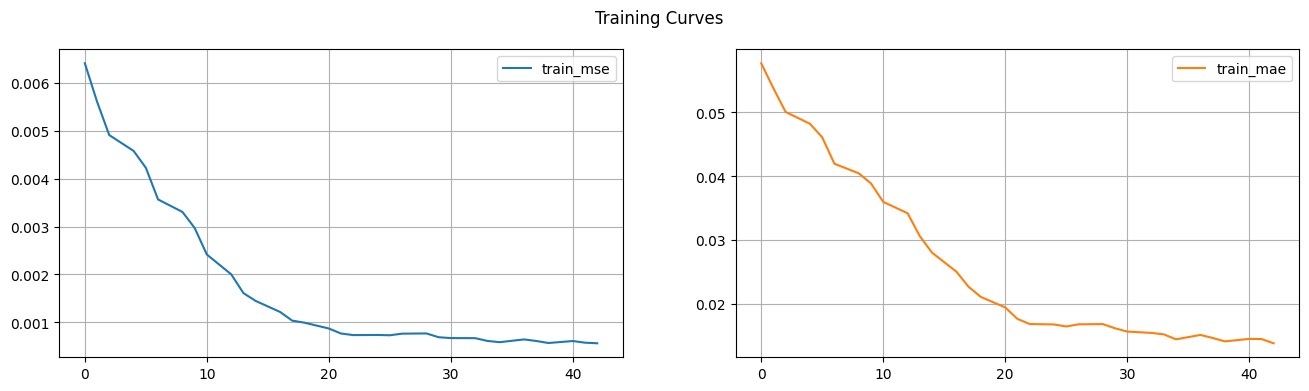

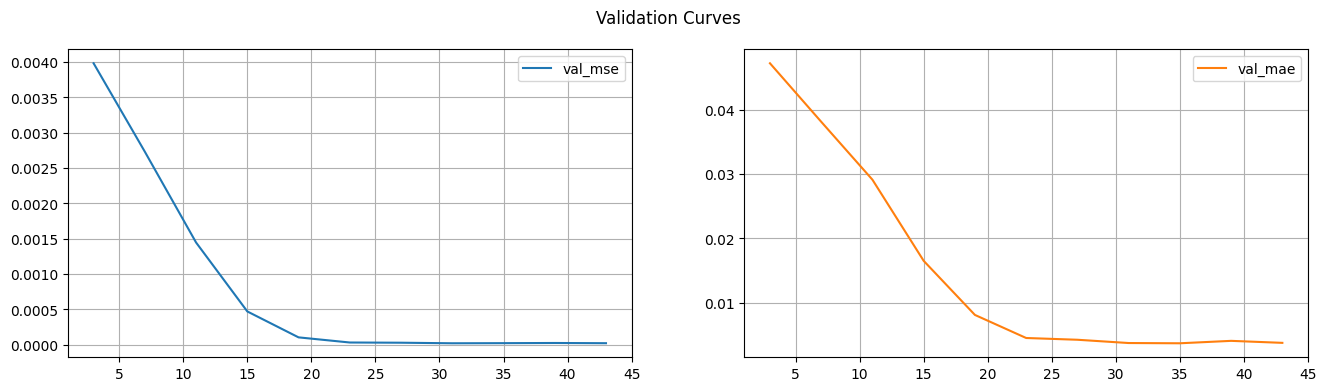

In [5]:
import os
import pandas as pd

num = len(os.listdir("./pl_logs_tmp/hae")) - 1
logs_to_read = f"./pl_logs_tmp/hae/version_{num}/metrics.csv"

hist = pd.read_csv(logs_to_read)
hist[['train_mse', 'train_mae']].dropna().plot(subplots=True, layout=(1,2), figsize=(16,4),
                                         grid=True, title="Training Curves")
hist[['val_mse', 'val_mae']].dropna().plot(subplots=True, layout=(1,2), figsize=(16,4),
                                         grid=True, title="Validation Curves")

In [8]:
min([item for item in os.listdir("checkpoints_tmp") if "hae-" in item], key=lambda x: float(x.split("-")[-2].split("=")[-1]))

'hae-epoch=07-val_mse=0.00-.ckpt'

## Pre-trained HAE Classifier

In [2]:
with open("data/sub_1000.json","r") as j_file:
    data = json.load(j_file)

train_dl, val_dl, test_dl, _ = load_data(data, batch_sizes=(30, 30, 20))


    train: 700
    val: 150
    test: 150
    


In [9]:
ckpt = min([item for item in os.listdir("checkpoints_tmp") if "hae-" in item], key=lambda x: float(x.split("-")[-2].split("=")[-1]))
pretrained_hae = PatientAutoencoder.load_from_checkpoint(checkpoint_path=f'checkpoints_tmp/{ckpt}')
encoder = nn.Sequential(
    pretrained_hae.encounter_autoencoder,
    pretrained_hae.patient_encoder
)

patient_latent_dim = 64  # Final latent space dimension for the patient
classifier_model = PatientClassifier(encoder=encoder, hidden_dim=patient_latent_dim)

logger = CSVLogger("pl_logs_tmp", name="hae_classifier")

# Initialize PyTorch Lightning trainer and train the model
trainer = L.Trainer(
    max_epochs=15,
    accelerator="gpu", # strategy="ddp_notebook",
    callbacks=[
        ModelCheckpoint(
            monitor="val_loss", mode="min", save_last=False, save_top_k=1,
            dirpath="checkpoints_tmp/", filename="hae_classifier-{epoch:02d}-{val_loss:.2f}"
        ),
        EarlyStopping(monitor="val_loss", patience=3, mode="min")
    ],
    logger=logger,
    devices=1,
    log_every_n_steps=5
)

trainer.fit(classifier_model, train_dataloaders=train_dl, val_dataloaders=val_dl)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: pl_logs_tmp/hae_classifier
/home/kolton.hauck/miniconda3/envs/python310/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/kolton.hauck/BMI6114_FinalProject/checkpoints_tmp exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]

  | Name          | Type              | Params
----------------------------------------------------
0 | encoder       | Sequential        | 3.0 M 
1 | classifier    | Linear            | 65    
2 | val_acc       | BinaryAccuracy    | 0     
3 | test_acc      | BinaryAccuracy    | 0     
4 | train_acc     | BinaryAccuracy    | 0     
5 | loss_function | BCEWithLogitsLoss | 0     
----------------------------------------------------
65        Trainable params
3.0 M     Non-trainable params
3.0 M     Total

Epoch 14: 100%|██████████| 29/29 [00:02<00:00, 10.86it/s, v_num=0, train_loss=0.673, train_acc=0.500, val_loss=0.711, val_acc=0.211]

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|██████████| 29/29 [00:02<00:00, 10.73it/s, v_num=0, train_loss=0.673, train_acc=0.500, val_loss=0.711, val_acc=0.211]


array([[<Axes: >, <Axes: >]], dtype=object)

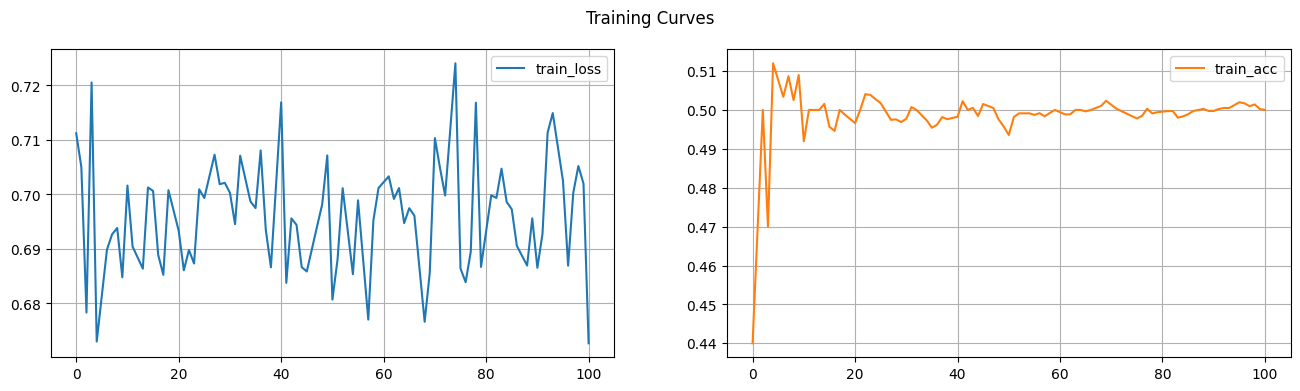

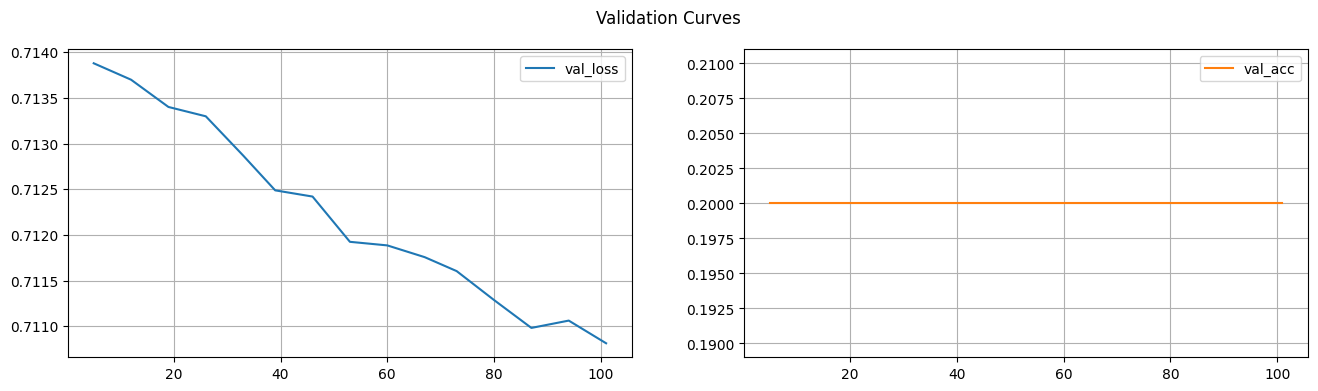

In [10]:
num = len(os.listdir("./pl_logs_tmp/hae_classifier")) - 1
logs_to_read = f"./pl_logs_tmp/hae_classifier/version_{num}/metrics.csv"

hist = pd.read_csv(logs_to_read)
hist[['train_loss', 'train_acc']].dropna().plot(subplots=True, layout=(1,2), figsize=(16,4),
                                         grid=True, title="Training Curves")
hist[['val_loss', 'val_acc']].dropna().plot(subplots=True, layout=(1,2), figsize=(16,4),
                                         grid=True, title="Validation Curves")

In [11]:
trainer.test(classifier_model, dataloaders=test_dl)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


Testing DataLoader 0: 100%|██████████| 8/8 [00:01<00:00,  6.84it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.2266666740179062
        test_loss           0.7092792391777039
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.7092792391777039, 'test_acc': 0.2266666740179062}]